# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10, SVHN
import torchvision.transforms as transforms
import seaborn as sns

# Select best device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets and setup the DataLoaders.
batch_size = 32
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)

ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

ds_ood = SVHN(root='./data', download=True, transform=transform, split='test')
dl_ood = torch.utils.data.DataLoader(ds_ood, batch_size=batch_size, shuffle=True, num_workers=2)

# In case we want to pretty-print classifications.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes_ood = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

100%|██████████| 170498071/170498071 [00:03<00:00, 54442586.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 64275384/64275384 [00:02<00:00, 29591176.27it/s]


> We will use CIFAR-10 as our IN Distribution dataset and Street View House Numbers as our Out Of Distribution.

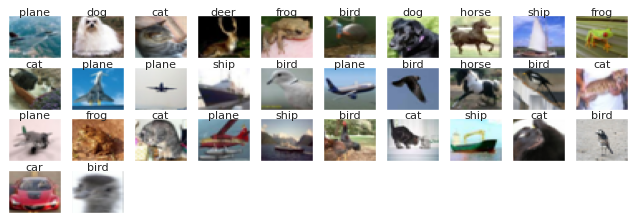

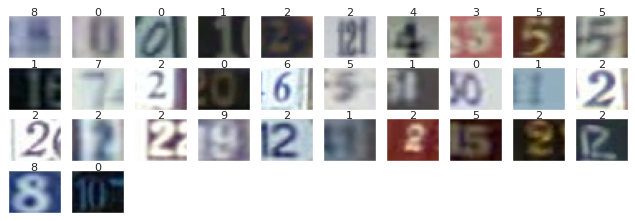

In [3]:
sns.set_theme()

def visualize_img(imgs, classes, labels, guesses=None):
    imgs = imgs / 2 + 0.5     # unnormalize to see original colors
    fig = plt.figure(figsize=(10,25), dpi=80)

    for i, img in enumerate(imgs):
        ax = fig.add_subplot(30,10, i+1)
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)), aspect='auto')

        ax.set_xticks([])
        ax.set_yticks([])
        if guesses != None:
          if guesses[i] != labels[i]:
            ax.set_title(f'{classes[int(guesses[i])]}', fontsize=10, y=1.0, pad=0, color='red') #for the uncorrect guesses
        ax.set_title(f'{classes[int(labels[i])]}', fontsize=10, y=1.0, pad=0)

    plt.show()


images, labels = next(iter(dl_train))
visualize_img(images, classes, labels)

img_ood, lab_ood = next(iter(dl_ood))
visualize_img(img_ood, classes_ood, lab_ood)

In [75]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def model_training(model, epochs, loader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Main training loop.
  for epoch in range(epochs):
      running_loss = 0.0
      # Iterate over all batches.
      for (Xs, ys) in loader:
          Xs = Xs.to(device)
          ys = ys.to(device)

          # Make a gradient step.
          optimizer.zero_grad()
          outputs = model(Xs)
          loss = criterion(outputs, ys)
          loss.backward()
          optimizer.step()

          # Track epoch loss.
          running_loss += loss.item()

      # Print average epoch loss.
      print(f'Epoch: {epoch + 1} -> Loss: {running_loss / len(dl_train):.3f}')

  print('Finished Training')

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

def model_test(model, loader):
  model.eval()
  correct = 0
  losses = []
  for images, labels in loader:
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      preds = model(images)
      loss = F.cross_entropy(preds, labels)
      correct += get_num_correct(preds, labels)
      losses.append(loss.item())
  print(f'Accuracy: {correct}')
  return (correct)

In [5]:
#CNN as seen in class, we take the pretrained version
model = CNN().to(device)
model.load_state_dict(torch.load('/content/cifar10_CNN.pth'))

<All keys matched successfully>

> The idea is to find a discriminator (λ) so that images with the highest logit > λ can be considered ID; instead if the highest logit is too low (< λ) it can be considered OOD

> We will now calculate the logits for the model on both distributions and try different metrics of comparison.

In [6]:
from scipy.special import softmax

def collect_logits(model, dl):
    logits = []
    with torch.no_grad():
        for (Xs, _) in dl:
            logits.append(model(Xs.to(device)).cpu().numpy())
    return np.vstack(logits)


def ood_max(logits):
  return logits.max(1)

def ood_std(logits):
  return logits.std(1)


In [7]:
logits_ID = collect_logits(model, dl_test)
logits_OOD = collect_logits(model, dl_ood)

In [8]:
print(len(logits_ID), len(logits_OOD))

10000 26032


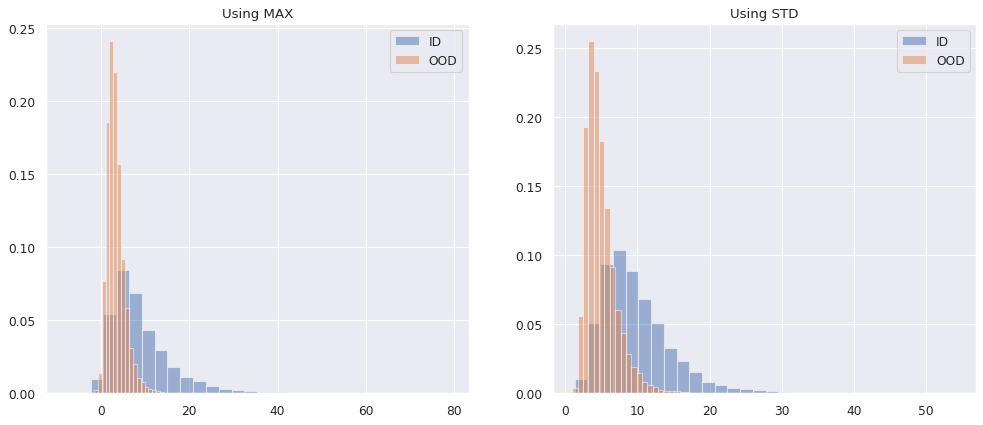

In [9]:
sns.set_theme()

from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=80)

(hist_id, _) = np.histogram(ood_max(logits_ID), 30, density=True)
(hist_ood, _) = np.histogram(ood_max(logits_OOD), 30, density=True)


(hist_id, _) = np.histogram(ood_std(logits_ID), 30, density=True)
(hist_ood, _) = np.histogram(ood_std(logits_OOD), 30, density=True)


#Plot histograms
plt.subplot(1,2,1)
_ = plt.hist(ood_max(logits_ID), 30, density=True, alpha=0.5, label='ID')
_ = plt.hist(ood_max(logits_OOD), 30, density=True, alpha=0.5, label='OOD')
plt.title("Using MAX")
plt.legend()

plt.subplot(1,2,2)
_ = plt.hist(ood_std(logits_ID), 30, density=True, alpha=0.5, label='ID')
_ = plt.hist(ood_std(logits_OOD), 30, density=True, alpha=0.5, label='OOD')
plt.title("Using STD")
plt.legend()

plt.show()



> The first histogram shows the frequency of the values for the highest (`max`) "probabilty" of each logit array. For the OOD data, the majority of images have very low max logit (between 0 and 1), while for the ID data it reaches easily values like 20 or 40. There are though many values "in common", the ones between 0 and 10, that make it impossible to determine a discriminator.

> Using the STD of the logits instead of the max logit gives similar results: there is still a big overlapping between the two histograms.


### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


In [10]:
max_ID = ood_max(logits_ID)
max_OOD = ood_max(logits_OOD)

std_ID = ood_std(logits_ID)
std_OOD = ood_std(logits_OOD)

In [11]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

def roc(scores, labels):
  RocCurveDisplay.from_predictions(labels, scores)

def p_r(scores, labels):
  PrecisionRecallDisplay.from_predictions(labels, scores)

In [12]:
scores_max = np.hstack([max_ID, max_OOD])
labels_max = np.hstack([np.ones(len(ds_test),), np.zeros(len(ds_ood))])

scores_std = np.hstack([std_ID, std_OOD])
labels_std = np.hstack([np.ones(len(ds_test),), np.zeros(len(ds_ood))])


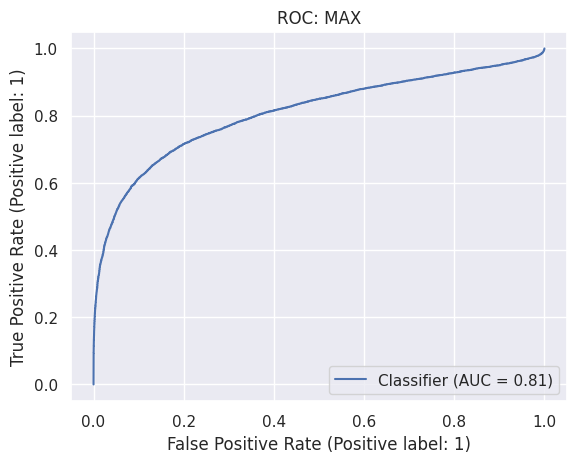

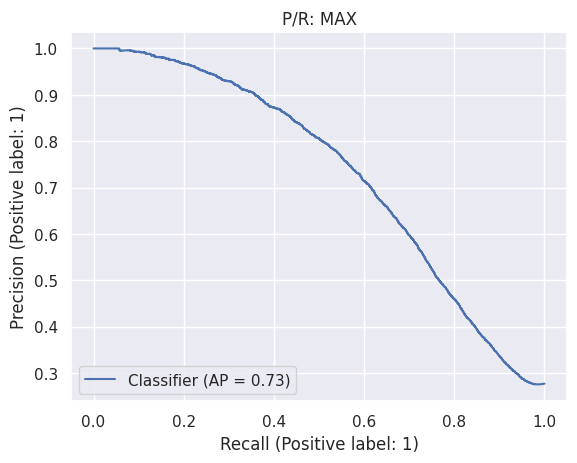

In [13]:
#ROC and P/R curves when using MAX:

roc(scores_max, labels_max)
plt.title("ROC: MAX")

p_r(scores_max, labels_max)
plt.title("P/R: MAX")

plt.show()

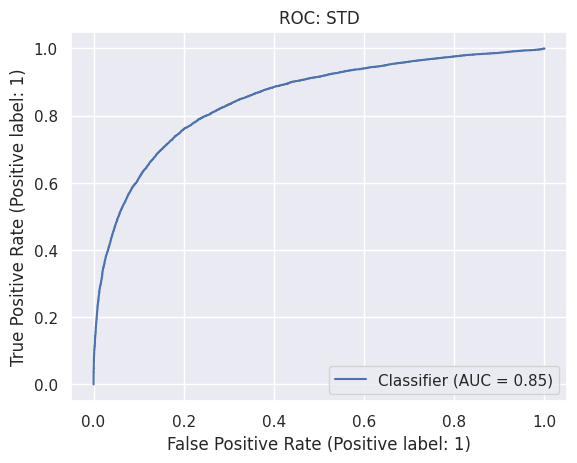

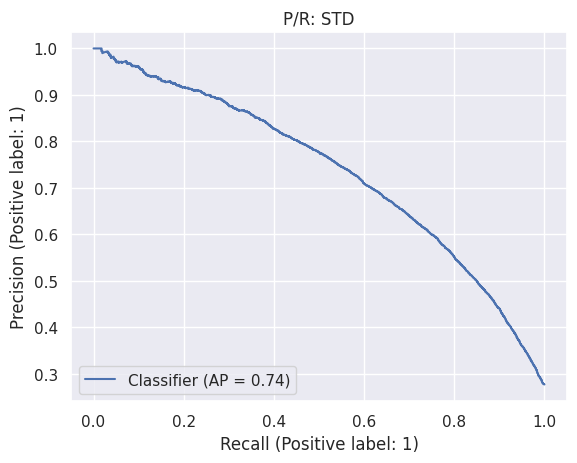

In [14]:
#ROC and P/R curves when using STD:

roc(scores_std, labels_std)
plt.title("ROC: STD")

p_r(scores_std, labels_std)
plt.title("P/R: STD")

plt.show()

> The ROC curve represents the relationship between TruePositiveRate and FalsePositiveRate. A perfect detector will have an area under the ROC curve of 1.0. This is not the case, but our best option for now is the STD version.

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

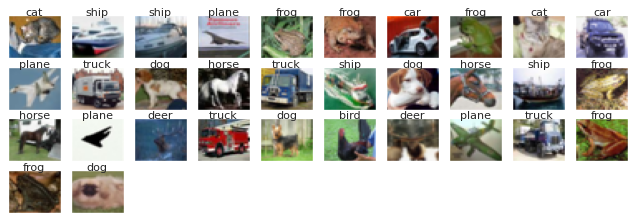

In [15]:
batch = next(iter(dl_test))
images, labels = batch
visualize_img(images, classes, labels)
#N.B. these are test set images, with the correct label

In [16]:
def fgsm_attack(model, image, img_grad, eps):
  eta = eps * img_grad.sign()
  return image + eta

Using epsilon: 0


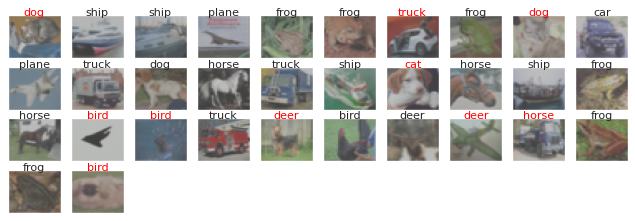

Guessed correctly: 22 


Using epsilon: 0.02


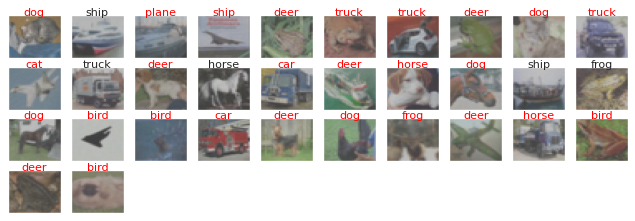

Guessed correctly: 5 


Using epsilon: 0.05


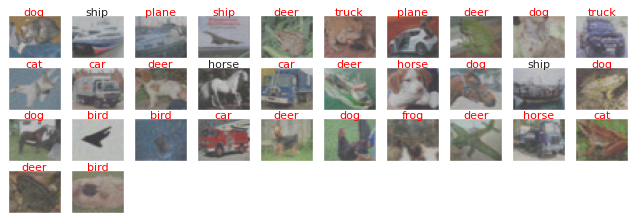

Guessed correctly: 3 


Using epsilon: 0.1


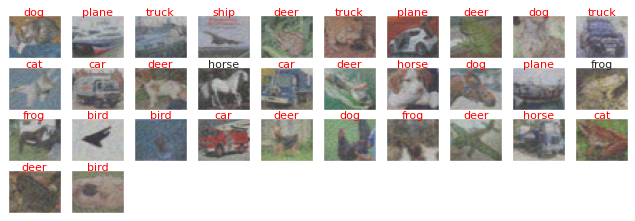

Guessed correctly: 2 


Using epsilon: 0.15


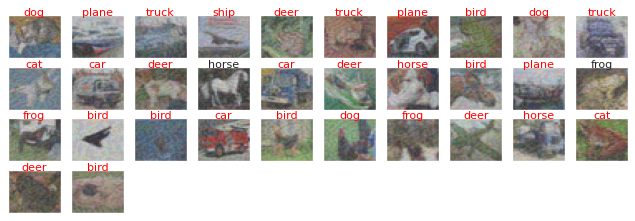

Guessed correctly: 2 




In [17]:
import warnings
warnings.filterwarnings("ignore")

epsilons = [0, 0.02, 0.05, 0.1, 0.15] #eps = 0: original

def attack_batch(model, images, labels, eps):
  correct = 0
  attacks = []
  outputs = []
  labels = labels.to(device)
  for idx, sample in enumerate(images):
    sample = sample.unsqueeze(0).to(device)
    sample.requires_grad = True
    criterion = nn.CrossEntropyLoss()

    loss = criterion(model(sample),torch.tensor(([labels[idx]])).to(device))
    loss.backward()
    sample_grad = sample.grad.data
    disturbed = fgsm_attack(model, sample, sample_grad, eps)
    #disturbed = torch.clamp(disturbed, 0, 255)
    attacks.append(disturbed[0]) #disturbed[0] = tensor(3, 32, 32)
    outputs.append(model(disturbed).max(1)[1][0]) #guessed class
    if classes[labels[idx]] == classes[outputs[idx]]:
      correct += 1
  attack_t = torch.stack((attacks))
  return attack_t, outputs, correct


for e in epsilons:
  attack_t, outputs, correct = attack_batch(model, images, labels, e)
  print(f'Using epsilon: {e}')
  visualize_img(attack_t.cpu().detach()/2, classes, outputs, labels) #the colors are pale but otherwise i get a imshow warning
  print(f"Guessed correctly: {correct} \n\n")

> Testing on a single batch: increasing the epsilon increases the difficulty that the model has in recognising the correct class. Eps=0 corresponds to the no-distortion case. The title of the single image is the guessed class, in black it if is correct and in red otherwise.

> We can extend the testing on the whole test loader




In [18]:
def attack(model, loader, eps):
  all_correct = []
  all_attacks = []
  all_outputs = []
  for batch in loader:
    img, labs = batch
    attack_t, outputs, correct = attack_batch(model, img, labs, eps)
    all_correct.append(correct)
    all_attacks.append(attack_t)
    all_outputs.append(outputs)
  return all_attacks, all_outputs, all_correct

In [19]:
total_corrects = []
total_attacks = []
total_outputs = []
for e in epsilons:
  attacks, outputs, corrects = attack(model, dl_test, e)
  print(f'Using e = {e} --> Total correct: {sum(corrects)}/10000, Accuracy: {sum(corrects)/10000*100}%')
  total_corrects.append(sum(corrects)/10000) #keep the result for plotting graph
  total_attacks.append(attacks) #keep all images for following ex
  total_outputs.append(outputs) #N.B. outputs is the (mostly wrong) guesses class id

Using e = 0 --> Total correct: 6008/10000, Accuracy: 60.08%
Using e = 0.02 --> Total correct: 1203/10000, Accuracy: 12.030000000000001%
Using e = 0.05 --> Total correct: 669/10000, Accuracy: 6.69%
Using e = 0.1 --> Total correct: 542/10000, Accuracy: 5.42%
Using e = 0.15 --> Total correct: 552/10000, Accuracy: 5.52%


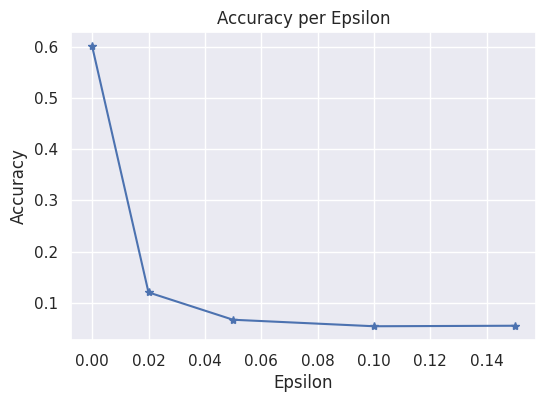

In [20]:
plt.figure(figsize=(6,4))
plt.plot(epsilons, total_corrects, "*-")
plt.title("Accuracy per Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

>As expected, the accuracy decreseas the more we increase epsilon (the distortion).

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

> Our model is weak as it is deeply affected by even the smallest perturbation. We can add these perturbed images to the training set and train the model again in an ` adversarial learning` loop.
> For semplicity, we only add to the training set the perturbed images obtained by using ϵ = 0.05. This is a very low perturbation (invisible to the human eye) that still deeply affects the model in recognising correctly the images.

In [21]:
print(len(ds_test))

10000


In [39]:
def transform_to_tensor(lista):
  T = []
  for i in range(len(lista)):
    t = torch.stack(lista[i])
    T.append(t)
  tens = torch.cat(T)
  return tens

all_labels = []
for img00, lab00 in dl_test:
  lab00 = lab00.to(device)
  all_labels.append(lab00)
all_labels_t = torch.cat(all_labels)


outputs_00 = transform_to_tensor(total_outputs[2]) #eps = 0.05
attacks_00 = torch.cat((total_attacks[2]))

print(outputs_00.size())
print(attacks_00.size())
print(all_labels_t.size())

torch.Size([10000])
torch.Size([10000, 3, 32, 32])
torch.Size([10000])


In [40]:
class PerturbedData(torch.utils.data.Dataset):
  def __init__(self, x, y):
    super(PerturbedData, self).__init__()
    # store the raw tensors
    self._x = x
    self._y = y


  def __len__(self):
    # a DataSet must know it size
    return self._x.shape[0]


  def __getitem__(self, index):
    x = self._x[index]
    y = self._y[index]
    return torch.tensor(x), torch.tensor(y)


ds_perm = PerturbedData(attacks_00, all_labels_t)
#We create a dataset with the perturbed images and the ORIGINAL labels

In [41]:
#We create a complete dataset with the original training data and perturbed images

ds_train_full = torch.utils.data.ConcatDataset([ds_train, ds_perm])
dl_train_full = torch.utils.data.DataLoader(ds_train_full, batch_size=100, shuffle=False)
print(len(ds_train_full))
print(len(ds_train))

60000
50000


In [42]:
dl_perturbed_only = torch.utils.data.DataLoader(ds_perm, batch_size=32, shuffle=True)
print(len(ds_perm))

10000


In [43]:
#test on the model trained on clean cifar10 data

model_test(model, dl_test) #original model on unpertubed data
model_test(model, dl_train_full) #original model on full perturbed data
model_test(model, dl_perturbed_only)

#N.B. since the permuted data is added to the train set, the model gets right most of the images from that part of the dataset (50000),
#but gets wrong the rest of the permuted data (as expected)

Accuracy: 6008 / Mean Loss: 2.4182142131625652
Accuracy: 45933 / Mean Loss: 3.248546017371118
Accuracy: 669 / Mean Loss: 18.211845425371163


(18.211845425371163, 669)

In [44]:
model_perm = CNN().to(device)

In [45]:
#We now create a new model and train in on clean cifar10 data + perturbed data
epochs = 20
model_training(model_perm, epochs, dl_train_full)

Epoch: 1 -> Loss: 0.648
Epoch: 2 -> Loss: 0.520
Epoch: 3 -> Loss: 0.475
Epoch: 4 -> Loss: 0.445
Epoch: 5 -> Loss: 0.422
Epoch: 6 -> Loss: 0.404
Epoch: 7 -> Loss: 0.388
Epoch: 8 -> Loss: 0.375
Epoch: 9 -> Loss: 0.363
Epoch: 10 -> Loss: 0.352
Epoch: 11 -> Loss: 0.342
Epoch: 12 -> Loss: 0.333
Epoch: 13 -> Loss: 0.325
Epoch: 14 -> Loss: 0.317
Epoch: 15 -> Loss: 0.311
Epoch: 16 -> Loss: 0.305
Epoch: 17 -> Loss: 0.298
Epoch: 18 -> Loss: 0.293
Epoch: 19 -> Loss: 0.287
Epoch: 20 -> Loss: 0.281
Finished Training


In [46]:
torch.save(model_perm.state_dict(), './data/model_perm_trained.pth')

In [ ]:
model_perm.load_state_dict(torch.load('/content/data/model_perm_trained.pth'))

In [47]:
model_test(model_perm, dl_test)
model_test(model_perm, dl_train_full)
model_test(model_perm, dl_perturbed_only)

Accuracy: 7679 / Mean Loss: 0.6652908312817352
Accuracy: 43585 / Mean Loss: 0.7704190335671107
Accuracy: 7381 / Mean Loss: 0.7340165703250958


(0.7340165703250958, 7381)

> After being trained on the perturbed data, the model is more capable of guessing the right class. In particular, in the perturbed only mini-dataset, it goes from guessing correctly only 1023 images out of 10.000 to 7378.

> We now try the same thing we did at the beginning to see if this new model trained on augmented data is more capable of detecting ID data from OOD one.

In [48]:
logits_ID = collect_logits(model_perm, dl_test)
logits_perm = collect_logits(model_perm, dl_perturbed_only)
logits_OOD = collect_logits(model_perm, dl_ood)

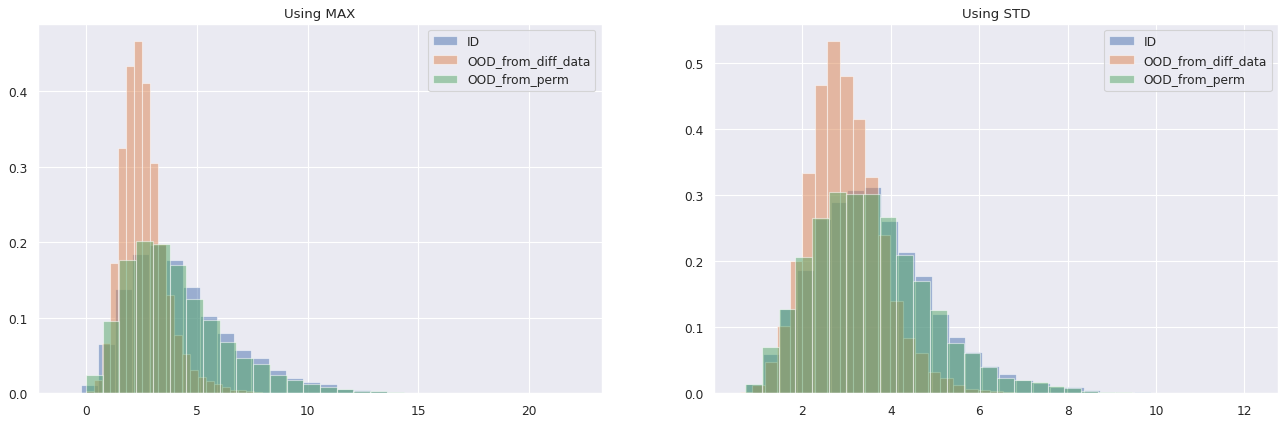

In [49]:
figure(figsize=(20, 6), dpi=80)
(hist_id, _) = np.histogram(ood_max(logits_ID), 30, density=True)
(hist_ood, _) = np.histogram(ood_max(logits_OOD), 30, density=True)
(hist_perm, _) = np.histogram(ood_max(logits_perm), 30, density=True)


(hist_id, _) = np.histogram(ood_std(logits_ID), 30, density=True)
(hist_ood, _) = np.histogram(ood_std(logits_OOD), 30, density=True)
(hist_perm, _) = np.histogram(ood_std(logits_perm), 30, density=True)


#Plot histograms
plt.subplot(1,2,1)
_ = plt.hist(ood_max(logits_ID), 30, density=True, alpha=0.5, label='ID')
_ = plt.hist(ood_max(logits_OOD), 30, density=True, alpha=0.5, label='OOD_from_diff_data')
_ = plt.hist(ood_max(logits_perm), 30, density=True, alpha=0.5, label='OOD_from_perm')
plt.title(f'Using MAX')
plt.legend()

plt.subplot(1,2,2)
_ = plt.hist(ood_std(logits_ID), 30, density=True, alpha=0.5, label='ID')
_ = plt.hist(ood_std(logits_OOD), 30, density=True, alpha=0.5, label='OOD_from_diff_data')
_ = plt.hist(ood_std(logits_perm), 30, density=True, alpha=0.5, label='OOD_from_perm')
plt.title(f'Using STD')
plt.legend()


plt.show()

> From the histograms, there is still a big overlapping. The OOD data (from perturbed images or a completely different dataset altogether) are very similar

In [58]:
#We consider only the roc and p_r using the std metric

std_ID = ood_std(logits_ID)
std_OOD = ood_std(logits_OOD)
std_perm = ood_std(logits_perm)

In [59]:
scores_std_ood = np.hstack([std_ID, std_OOD])
scores_std_perm = np.hstack([std_ID, std_perm])

labels_ood = np.hstack([np.ones(len(ds_test),), np.zeros(len(ds_ood))])
labels_perm = np.hstack([np.ones(10000), np.zeros(10000)])

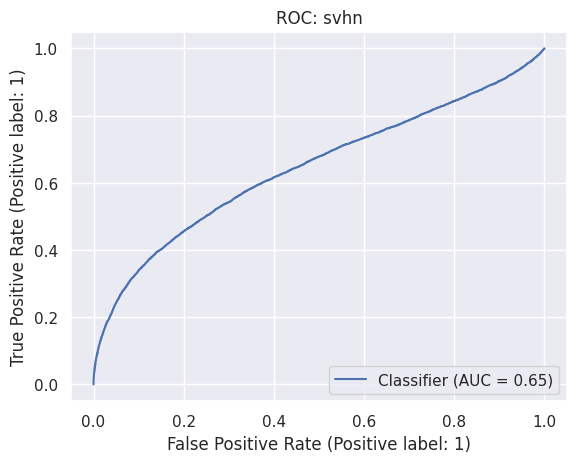

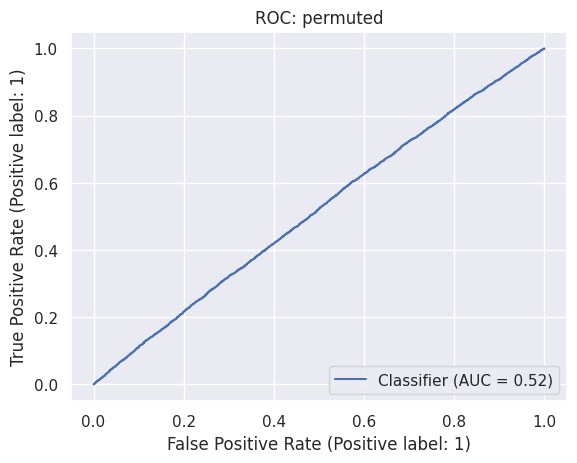

In [61]:
roc(scores_std_ood, labels_ood)
plt.title("ROC: svhn")
roc(scores_std_perm, labels_perm)
plt.title("ROC: permuted")

plt.show()

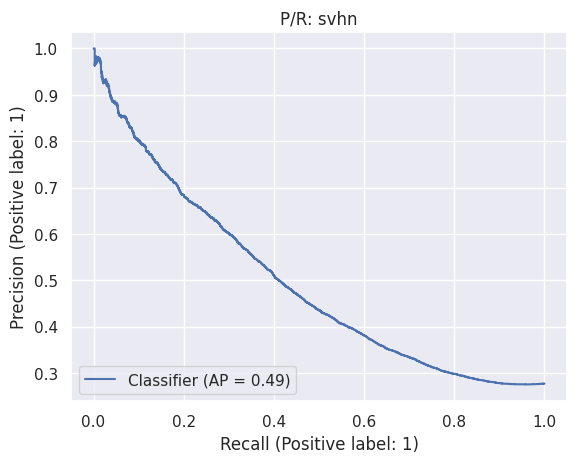

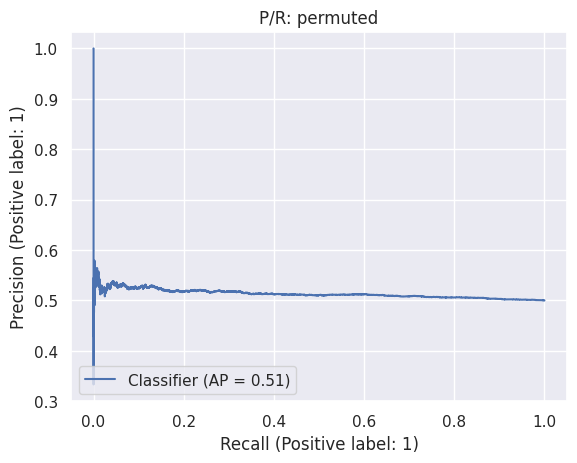

In [62]:
p_r(scores_std_ood, labels_ood)
plt.title("P/R: svhn")
p_r(scores_std_perm, labels_perm)
plt.title("P/R: permuted")

plt.show()

In [76]:
model_test(model, dl_ood)
model_test(model_perm, dl_ood)

Accuracy: 2706
Accuracy: 2768


2768

> I think that, since the model is trained to recognize perturbed data as if it was clear to guess correcly, when it's tested on OOD data, it treats those images as if 'perturbed ID', and that's why the accuracy increases.
> Detecting OOD and being able to guess correclty perturbed data are two different objectives that are in contrast with one another.

>If we trained the model on even more perturbed data maybe the OOD detection will get even worse (and the accuracy on the ood dataset better?)

In [69]:
outputs_03 = transform_to_tensor(total_outputs[3])
attacks_03 = torch.cat((total_attacks[3]))

outputs_04 = transform_to_tensor(total_outputs[4])
attacks_04 = torch.cat((total_attacks[4]))

ds_perm_03 = PerturbedData(attacks_03, all_labels_t)
ds_perm_04 = PerturbedData(attacks_04, all_labels_t)

ds_train_full = torch.utils.data.ConcatDataset([ds_train, ds_perm_03])
ds_train_full = torch.utils.data.ConcatDataset([ds_train_full, ds_perm_04])
dl_train_full = torch.utils.data.DataLoader(ds_train_full, batch_size=100, shuffle=False)
print(len(ds_train_full))
print(len(ds_train))

70000
50000


In [72]:
model_more_perm = CNN().to(device)
model_more_perm.load_state_dict(torch.load('/content/data/model_perm_trained.pth'))

<All keys matched successfully>

In [73]:
epochs = 10
model_training(model_more_perm, epochs, dl_train_full)

Epoch: 1 -> Loss: 0.349
Epoch: 2 -> Loss: 0.341
Epoch: 3 -> Loss: 0.331
Epoch: 4 -> Loss: 0.322
Epoch: 5 -> Loss: 0.314
Epoch: 6 -> Loss: 0.309
Epoch: 7 -> Loss: 0.307
Epoch: 8 -> Loss: 0.308
Epoch: 9 -> Loss: 0.303
Epoch: 10 -> Loss: 0.296
Finished Training


In [77]:
model_test(model, dl_ood)
model_test(model_perm, dl_ood)
model_test(model_more_perm, dl_ood)

Accuracy: 2706
Accuracy: 2768
Accuracy: 2793


2793

> .... yes! :)

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


In [63]:
#Choosing Ex 3.3

def attack_batch_trgt(model, images, labels, target, eps):
  labels = labels.to(device)
  successful_attacks = 0
  attacks = []
  outputs = []

  for idx, sample in enumerate(images):
    sample = sample.unsqueeze(0).to(device)
    sample.requires_grad = True

    output = model(sample)
    init_pred = output.argmax(dim=1, keepdim=True)

    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, torch.tensor([target]).to(device))
    model.zero_grad()
    loss.backward()
    sample_grad = sample.grad.data

    perturbed = fgsm_attack(model, sample, sample_grad, eps)

    new_output = model(perturbed)
    new_pred = new_output.argmax(dim=1, keepdim=True)

    outputs.append(new_pred[0].item())
    attacks.append(perturbed[0])

    #print(init_pred[0].item(), new_pred[0].item(), target, labels[idx].item())

    #attack successful if the prediction is the target without it being its original label
    if new_pred[0].item() == target and labels[idx].item() != target:
      successful_attacks += 1

  attack_t = torch.stack((attacks))
  return attack_t, outputs, successful_attacks


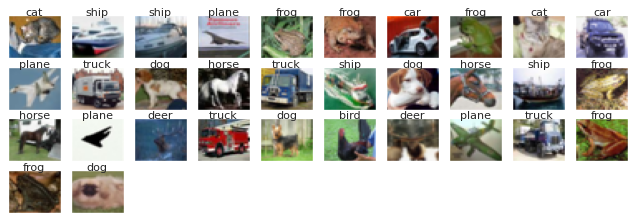

Original images 


Using epsilon: 0.01


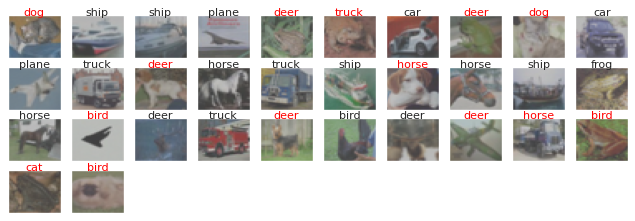

Attacked into frog: 0


Using epsilon: 0.02


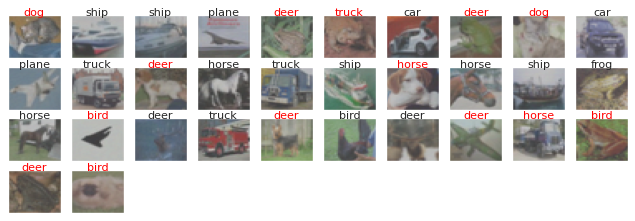

Attacked into frog: 0


Using epsilon: 0.05


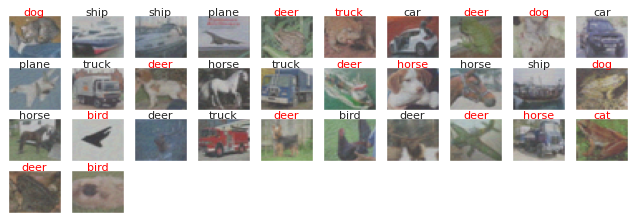

Attacked into frog: 0


Using epsilon: 0.1


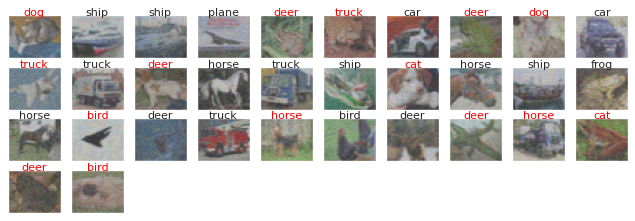

Attacked into frog: 0


Using epsilon: 0.15


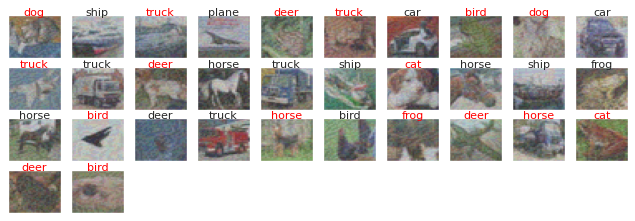

Attacked into frog: 1


Using epsilon: 0.25


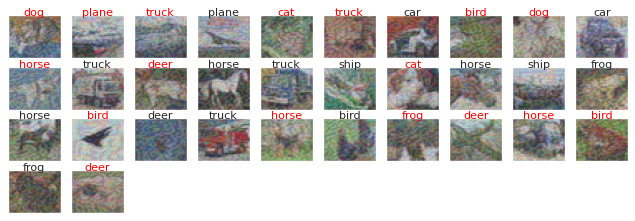

Attacked into frog: 1




In [64]:
batch = next(iter(dl_test))
images, labels = batch
visualize_img(images, classes, labels)
print('Original images \n\n')

target = 6 #frog
epsilons = [0.01, 0.02, 0.05, 0.1, 0.15, 0.25]

for e in epsilons:
  attack_t, outputs, attacked = attack_batch_trgt(model, images, labels, target, e)
  print(f'Using epsilon: {e}')
  visualize_img(attack_t.cpu().detach()/2, classes, outputs, labels)
  print(f'Attacked into {classes[target]}: {attacked}\n\n')


Using epsilon: 0.4


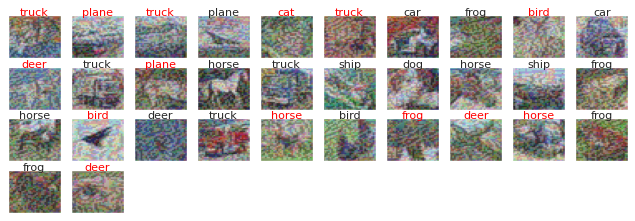

Attacked into frog: 1


Using epsilon: 0.5


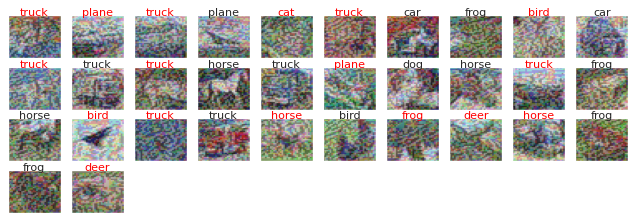

Attacked into frog: 1


Using epsilon: 0.8


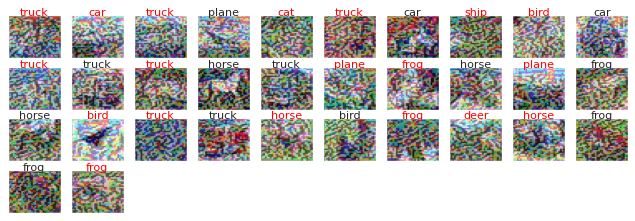

Attacked into frog: 3


Using epsilon: 1.0


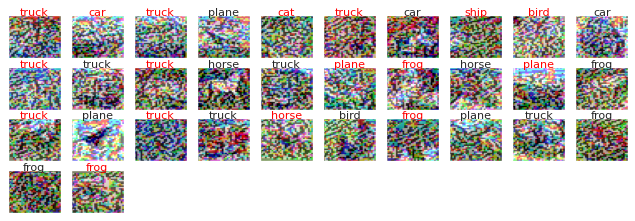

Attacked into frog: 3




In [65]:
epsilons0 = [0.4, 0.5, 0.8, 1.0] #trying with very high eps (the degradation effect is very much visible)

for e in epsilons0:
  attack_t, outputs, attacked = attack_batch_trgt(model, images, labels, target, e)
  print(f'Using epsilon: {e}')
  visualize_img(attack_t.cpu().detach()/2, classes, outputs, labels)
  print(f'Attacked into {classes[target]}: {attacked}\n\n')

> It seems like targeting the model to misclassify the image with the specific class that we want is much harder than the vanilla case, even with very high epsilons.

In [66]:
def attack_trgt(model, loader, target, eps):
  successful_attacks = []
  for batch in loader:
    img, labs = batch
    attack_t, outputs, attacked = attack_batch_trgt(model, img, labs, target, eps)
    successful_attacks.append(attacked)
  return successful_attacks

target = 6 #frog
correct_per_e = []
for e in epsilons:
  attacked = attack_trgt(model, dl_test, target, e)
  print(f'Using e = {e} --> Total attacked into {classes[target]}s: {sum(attacked)}/10000, Attack Rate: {sum(attacked)/10000*100}%')
  correct_per_e.append(sum(attacked)/10000) #keep the result for plotting graph

Using e = 0.01 --> Total attacked into frogs: 9/10000, Attack Rate: 0.09%
Using e = 0.02 --> Total attacked into frogs: 3/10000, Attack Rate: 0.03%
Using e = 0.05 --> Total attacked into frogs: 2/10000, Attack Rate: 0.02%
Using e = 0.1 --> Total attacked into frogs: 11/10000, Attack Rate: 0.11%
Using e = 0.15 --> Total attacked into frogs: 39/10000, Attack Rate: 0.38999999999999996%
Using e = 0.25 --> Total attacked into frogs: 174/10000, Attack Rate: 1.7399999999999998%


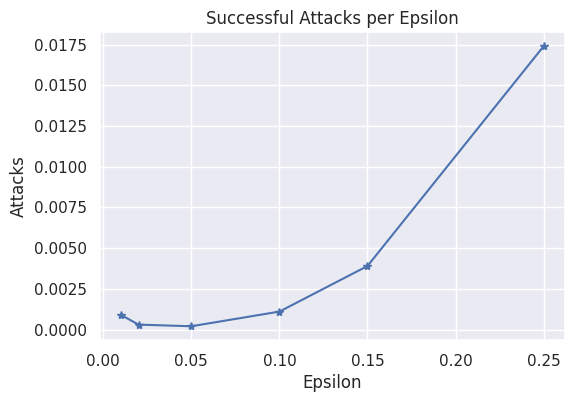

In [67]:
plt.figure(figsize=(6,4))
plt.plot(epsilons, correct_per_e, "*-")
plt.title("Successful Attacks per Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Attacks")
plt.show()

> As expected, increasing the epsilons increases the fragilty of the model, and the attack success rate.

>N.B. For the sake of the exercise I made two different functions, but the main difference between the untargeted and targeted attack is only in the `loss`: in the first case it is calculated between the predictions and the true label, whilst in the latter between the predicions and the target label.